# Библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
import lightgbm as lgb
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
import zipfile
pd.reset_option('display.max_rows')
pd.set_option('display.max_columns', None)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Функции

In [2]:
def plot_predictions(y_test, y_pred):
    """
    Функция строит графики реальных и предсказанных значений, график остатков и выводит значения метрик.

    Параметры:
    y_test (array-like): 
        Реальные значения.
    y_pred (array-like):
        Предсказанные значения.
    """
    fig, axs = plt.subplots(4, 1, figsize=(10, 20))
    line = np.linspace(min(y_test), max(y_test), 1000)

    axs[0].scatter(y_test, y_test, color='blue')
    axs[0].plot(line, line, color='green', alpha=0.1)
    axs[0].set_title('Реальные значения')
    axs[0].set_xlabel('Реальные значения')
    axs[0].set_ylabel('Реальные значения')

    axs[1].scatter(y_test, y_pred, color='red')
    axs[1].plot(line, line, color='green', alpha=0.1)
    axs[1].set_title('Предсказанные значения')
    axs[1].set_xlabel('Реальные значения')
    axs[1].set_ylabel('Предсказанные значения')

    axs[2].scatter(y_test, y_test, color='blue', alpha=0.6, label='Реальные значения')
    axs[2].scatter(y_test, y_pred, color='red', alpha=0.6, label='Предсказанные значения')
    axs[2].plot(line, line, color='green', alpha=0.1)
    axs[2].set_title('Предсказанные значения наложенные на реальные значения')
    axs[2].set_xlabel('Реальные значения')
    axs[2].set_ylabel('Предсказанные значения')
    axs[2].legend()

    residuals = y_test - y_pred
    axs[3].scatter(y_test, residuals, color='purple')
    axs[3].axhline(y=0, color='green', alpha=0.1)
    axs[3].set_title('График остатков')
    axs[3].set_xlabel('Реальные значения')
    axs[3].set_ylabel('Остатки')

    plt.tight_layout()
    plt.show()

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Средняя абсолютная ошибка (MAE): {mae:.4f}")
    print(f"Среднеквадратичная ошибка (MSE): {mse:.4f}")
    print(f"Коэффициент детерминации (R^2): {r2:.4f}")
    print(f"\nКорень из среднеквадратичной ошибки (RMSE): {rmse:.4f}")

# Загрузка данных

In [3]:
df_train = pd.read_csv('train.csv', index_col=0)
df_train

,full_sq,floor,build_year,num_room,kitch_sq,state,product_type,raion_popul,indust_part,sport_objects_raion,shopping_centers_raion,radiation_raion,build_count_block,build_count_brick,build_count_monolith,metro_min_avto,school_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,ID_railroad_station_avto,mkad_km,ttk_km,oil_chemistry_km,nuclear_reactor_km,power_transmission_line_km,market_shop_km,fitness_km,stadium_km,basketball_km,detention_facility_km,additional_education_km,big_church_km,mosque_km,theater_km,exhibition_km,catering_km,green_part_1000,cafe_sum_1000_min_price_avg,cafe_count_1000_price_high,cafe_sum_1500_min_price_avg,green_part_2000,cafe_sum_2000_min_price_avg,mosque_count_3000,prom_part_5000,cafe_sum_5000_min_price_avg,mosque_count_5000,year,price_doc
0,43,24.0,2014.0,1.0,10.0,1.0,1,8.294300,0.007122,0,1,0,42.0,67.0,6.0,2.868785,1.692061,0.038518,0.288225,2.830465,1.790982,2.972399,3.178054,2.027581,2.868588,3.414810,2.883189,1.780660,1.946851,1.992371,2.655407,2.174190,3.244840,1.719353,0.416690,2.574236,2.624072,1.614995,-0.818240,43.01,6.907755,0,6.907755,3.710396,6.725430,0,1.803359,6.616560,0,2014,5533460
1,66,3.0,1979.0,3.0,10.0,3.0,0,11.314231,0.232205,4,3,0,41.0,23.0,7.0,2.723498,0.544072,0.084900,0.928580,3.124008,0.762693,1.214024,3.218876,1.119248,2.156065,2.733947,1.868145,0.575118,0.657226,0.078858,1.473900,0.880697,0.782086,0.823799,-0.220450,1.040107,1.963272,1.455457,-1.980713,21.98,6.668863,0,6.626122,2.764431,6.479615,1,2.631169,6.469948,1,2013,9900000
2,55,5.0,1979.0,2.0,6.0,2.0,0,11.718817,0.000170,5,1,1,72.0,22.0,7.0,5.191637,0.131759,0.153194,0.852333,2.422202,0.384820,2.144684,4.912655,-0.589601,2.183655,1.632509,2.845103,0.288546,1.350267,0.556217,1.464339,0.467441,2.259530,2.160799,-0.738825,1.896468,1.504124,1.405330,-0.421970,7.44,6.620073,0,6.368753,3.511844,6.192138,0,1.363537,6.462171,0,2012,1990000
3,45,7.0,1970.0,2.0,6.0,2.0,0,11.331032,0.428826,4,2,1,53.0,114.0,5.0,3.973451,0.652399,0.550491,0.433175,0.636154,3.593367,2.273569,4.624973,1.917709,1.664886,1.772033,1.460506,1.169463,0.732397,1.176763,1.595057,0.505019,-0.007625,0.428088,0.198203,2.004970,2.021288,0.672287,-0.902659,2.33,6.684612,0,6.753601,1.814825,6.551080,0,2.732418,6.458229,0,2014,6500000
4,43,4.0,1968.0,2.0,6.0,2.0,0,11.538769,0.136330,6,6,1,130.0,28.0,18.0,0.948945,0.346969,0.082233,1.292605,2.037110,4.232449,2.235717,3.737670,1.994853,1.399582,2.735390,1.112179,0.304474,1.120563,0.157995,1.766593,0.184198,2.630160,1.106380,0.288248,0.862103,-0.714591,0.978309,-2.179325,7.20,6.639876,0,6.636603,2.257588,6.646507,1,2.020222,6.634778,2,2014,8500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21324,56,19.0,1979.0,2.0,1.0,1.0,1,11.655744,0.049637,6,3,0,83.0,67.0,4.0,2.831088,0.594672,0.623781,0.030182,0.569256,4.922221,2.295246,0.693147,2.147622,1.101061,2.106816,1.506429,0.671596,1.656252,0.369648,2.022591,-0.584968,2.638305,0.680710,0.893273,1.859525,2.170206,1.083347,-0.204948,1.23,5.991465,0,6.492240,2.711378,6.816188,0,3.297317,6.536155,0,2014,10159562
21325,42,5.0,1977.0,1.0,8.0,3.0,0,11.718817,0.000170,5,1,1,72.0,22.0,7.0,4.304029,0.331162,0.155563,1.187356,2.464136,0.894532,2.202226,4.912655,-0.037076,2.137794,1.581641,2.844848,0.049471,1.187312,0.282911,1.320284,0.613809,2.197046,2.083100,-0.018809,1.944898,1.402047,1.340352,-0.141583,30.66,6.214608,0,6.502295,3.802208,6.291569,0,1.442202,6.487684,0,2014,5100000
21326,32,3.0,1979.0,2.0,6.0,2.0,0,11.719940,0.000000,4,2,1,223.0,45.0,8.0,2.089498,0.334345,0.095533,1.226563,1.788982,4.606222,1.852781,0.693147,1.976098,1.748689,2.654337,1.638682,-2.167212,0.296555,0.696230,1.925911,1.409956,2.713736,1.144178,-0.204497,0.779057,1.273657,0.764080,-1.010884,14.06,6.487897,0,6.572814,3.062456,6.583520,1,2.733718,6.573904,2,2011,4800000
21327,43,4.0,1969.0,2.0,5.0,2.0,0,11.331032,0

In [4]:
df_test = pd.read_csv('test.csv', index_col=0)
df_test

,full_sq,floor,build_year,num_room,kitch_sq,state,product_type,raion_popul,indust_part,sport_objects_raion,shopping_centers_raion,radiation_raion,build_count_block,build_count_brick,build_count_monolith,metro_min_avto,school_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,ID_railroad_station_avto,mkad_km,ttk_km,oil_chemistry_km,nuclear_reactor_km,power_transmission_line_km,market_shop_km,fitness_km,stadium_km,basketball_km,detention_facility_km,additional_education_km,big_church_km,mosque_km,theater_km,exhibition_km,catering_km,green_part_1000,cafe_sum_1000_min_price_avg,cafe_count_1000_price_high,cafe_sum_1500_min_price_avg,green_part_2000,cafe_sum_2000_min_price_avg,mosque_count_3000,prom_part_5000,cafe_sum_5000_min_price_avg,mosque_count_5000,year
0,39,4.0,1979.0,2.0,6.0,2.0,0,12.419041,0.090799,16,15,0,3.0,4.0,17.0,2.165861,0.147556,0.170420,1.475158,1.104952,1.073515,2.080026,2.772589,1.392881,2.115977,1.479443,1.355364,-1.322760,0.191903,0.213466,2.028943,1.170693,1.129259,0.262734,-0.285141,2.046173,2.332643,0.978010,-1.003724,27.71,6.396930,0,6.448605,2.996732,6.303241,0,2.520113,6.459278,0,2011
1,28,1.0,1979.0,2.0,6.0,2.0,0,12.018097,0.133215,13,4,1,58.0,209.0,4.0,1.402401,0.223022,0.449427,0.562567,1.150458,2.270123,2.377894,2.833213,1.702367,1.702891,1.610474,1.704648,1.229427,0.215018,0.400246,1.408162,-0.497302,1.543901,1.190042,-1.040694,2.168354,1.745304,1.139911,-0.406035,5.63,6.684612,0,6.694178,2.773838,6.513097,0,2.863914,6.496021,0,2012
2,38,3.0,1979.0,2.0,6.0,2.0,0,11.262899,0.195781,2,2,0,71.0,105.0,4.0,1.716016,0.167914,0.427386,0.522147,1.380482,3.910716,1.835218,0.693147,2.176477,1.582322,2.505367,1.434325,0.327853,-0.368654,0.353373,1.960999,1.187520,2.551791,0.926111,0.753745,0.099388,0.482398,-1.924079,-1.181752,1.92,6.407985,0,6.545967,2.156403,6.466891,1,3.064325,6.572366,1,2012
3,38,3.0,1979.0,2.0,6.0,2.0,1,9.164611,0.072158,1,0,0,42.0,67.0,6.0,7.132375,2.883598,0.035035,0.424423,1.709037,3.359101,2.174799,4.290459,0.915597,2.753252,3.048251,2.614743,-1.114898,2.022965,1.445152,2.684398,1.763692,3.224599,3.631929,1.425543,1.256516,2.653971,2.089293,0.412722,31.84,6.506128,0,6.540034,3.733853,6.214608,0,1.962908,6.664128,1,2012
4,53,10.0,2009.0,2.0,9.0,2.0,0,11.482043,0.122090,7,0,0,101.0,216.0,11.0,1.338043,0.258376,0.400178,0.325128,3.062183,2.593761,0.917256,2.197225,1.827193,1.800156,2.811634,0.173754,-0.623408,1.190584,0.850225,0.851996,-1.680091,1.447375,0.696804,0.567319,1.115930,1.976331,0.927116,-0.817383,3.85,5.703782,0,6.318157,2.269028,6.416732,0,2.869035,6.500013,1,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9137,54,4.0,1975.0,2.0,9.0,3.0,0,10.187839,0.000000,20,5,0,17.0,134.0,16.0,1.269094,1.006318,0.257613,1.402309,2.096540,1.490366,2.636322,3.465736,2.562574,0.890058,2.291475,1.284277,1.464899,1.157284,0.295314,1.227908,0.267047,1.804851,0.701003,-0.824019,0.689626,0.054438,0.436575,-2.368886,25.33,6.637795,0,6.695205,2.564180,6.775925,1,2.169054,6.802828,1,2014
9138,30,2.0,1979.0,2.0,6.0,2.0,0,12.024569,0.111627,18,3,1,208.0,125.0,49.0,6.377488,0.158074,0.202388,1.057006,2.922134,4.342457,2.425829,4.394449,1.733531,1.552211,2.926528,0.613859,0.939284,1.259870,0.130690,0.947379,0.011217,1.784375,0.240411,0.336779,1.854748,2.306994,0.632270,-1.622894,8.17,6.663554,0,6.684612,2.899772,6.633318,0,2.449279,6.624397,0,2013
9139,41,2.0,1961.0,2.0,6.0,2.0,0,11.457000,0.038693,7,5,1,108.0,105.0,4.0,1.097456,0.147277,0.273060,1.322936,2.350696,1.795429,2.101041,3.433987,0.326449,2.028704,1.336626,2.723715,0.272647,0.679318,0.256284,1.311505,-0.527575,2.193402,0.280992,-1.299794,2.100664,0.495588,1.057806,-0.965761,19.55,6.339777,0,6.346671,3.037354,6.339777,0,1.798404,6.483780,0,2014
9140,78,5.0,1979.0,3.0,0.0,2.0,1,11.274795,0.437885,3,5,1,55.0,28.0,12.0,2.894451,0.431915,0.481168,0.385530,2.897434

In [5]:
submission = pd.read_csv('submission_example.csv', index_col=0)
submission

,price_doc
0,7.135718e+06
1,7.135718e+06
2,7.135718e+06
3,7.135718e+06
4,7.135718e+06
...,...
9137,7.135718e+06
9138,7.135718e+06
9139,7.135718e+06
9140,7.135718e+06


# Предобработка данных

In [137]:
# Удалим дубликаты из train
columns_except_price_doc = df_train.columns[df_train.columns != 'price_doc'].tolist()
df_train = df_train.drop_duplicates(subset=columns_except_price_doc, keep=False)

In [138]:
# Соединим выборки для удобства предобработки
df_pre = pd.concat([df_train, df_test], axis=0)
df_pre

,full_sq,floor,build_year,num_room,kitch_sq,state,product_type,raion_popul,indust_part,sport_objects_raion,shopping_centers_raion,radiation_raion,build_count_block,build_count_brick,build_count_monolith,metro_min_avto,school_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,ID_railroad_station_avto,mkad_km,ttk_km,oil_chemistry_km,nuclear_reactor_km,power_transmission_line_km,market_shop_km,fitness_km,stadium_km,basketball_km,detention_facility_km,additional_education_km,big_church_km,mosque_km,theater_km,exhibition_km,catering_km,green_part_1000,cafe_sum_1000_min_price_avg,cafe_count_1000_price_high,cafe_sum_1500_min_price_avg,green_part_2000,cafe_sum_2000_min_price_avg,mosque_count_3000,prom_part_5000,cafe_sum_5000_min_price_avg,mosque_count_5000,year,price_doc
0,43,24.0,2014.0,1.0,10.0,1.0,1,8.294300,0.007122,0,1,0,42.0,67.0,6.0,2.868785,1.692061,0.038518,0.288225,2.830465,1.790982,2.972399,3.178054,2.027581,2.868588,3.414810,2.883189,1.780660,1.946851,1.992371,2.655407,2.174190,3.244840,1.719353,0.416690,2.574236,2.624072,1.614995,-0.818240,43.01,6.907755,0,6.907755,3.710396,6.725430,0,1.803359,6.616560,0,2014,5533460.0
1,66,3.0,1979.0,3.0,10.0,3.0,0,11.314231,0.232205,4,3,0,41.0,23.0,7.0,2.723498,0.544072,0.084900,0.928580,3.124008,0.762693,1.214024,3.218876,1.119248,2.156065,2.733947,1.868145,0.575118,0.657226,0.078858,1.473900,0.880697,0.782086,0.823799,-0.220450,1.040107,1.963272,1.455457,-1.980713,21.98,6.668863,0,6.626122,2.764431,6.479615,1,2.631169,6.469948,1,2013,9900000.0
2,55,5.0,1979.0,2.0,6.0,2.0,0,11.718817,0.000170,5,1,1,72.0,22.0,7.0,5.191637,0.131759,0.153194,0.852333,2.422202,0.384820,2.144684,4.912655,-0.589601,2.183655,1.632509,2.845103,0.288546,1.350267,0.556217,1.464339,0.467441,2.259530,2.160799,-0.738825,1.896468,1.504124,1.405330,-0.421970,7.44,6.620073,0,6.368753,3.511844,6.192138,0,1.363537,6.462171,0,2012,1990000.0
3,45,7.0,1970.0,2.0,6.0,2.0,0,11.331032,0.428826,4,2,1,53.0,114.0,5.0,3.973451,0.652399,0.550491,0.433175,0.636154,3.593367,2.273569,4.624973,1.917709,1.664886,1.772033,1.460506,1.169463,0.732397,1.176763,1.595057,0.505019,-0.007625,0.428088,0.198203,2.004970,2.021288,0.672287,-0.902659,2.33,6.684612,0,6.753601,1.814825,6.551080,0,2.732418,6.458229,0,2014,6500000.0
4,43,4.0,1968.0,2.0,6.0,2.0,0,11.538769,0.136330,6,6,1,130.0,28.0,18.0,0.948945,0.346969,0.082233,1.292605,2.037110,4.232449,2.235717,3.737670,1.994853,1.399582,2.735390,1.112179,0.304474,1.120563,0.157995,1.766593,0.184198,2.630160,1.106380,0.288248,0.862103,-0.714591,0.978309,-2.179325,7.20,6.639876,0,6.636603,2.257588,6.646507,1,2.020222,6.634778,2,2014,8500000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9137,54,4.0,1975.0,2.0,9.0,3.0,0,10.187839,0.000000,20,5,0,17.0,134.0,16.0,1.269094,1.006318,0.257613,1.402309,2.096540,1.490366,2.636322,3.465736,2.562574,0.890058,2.291475,1.284277,1.464899,1.157284,0.295314,1.227908,0.267047,1.804851,0.701003,-0.824019,0.689626,0.054438,0.436575,-2.368886,25.33,6.637795,0,6.695205,2.564180,6.775925,1,2.169054,6.802828,1,2014,NaN
9138,30,2.0,1979.0,2.0,6.0,2.0,0,12.024569,0.111627,18,3,1,208.0,125.0,49.0,6.377488,0.158074,0.202388,1.057006,2.922134,4.342457,2.425829,4.394449,1.733531,1.552211,2.926528,0.613859,0.939284,1.259870,0.130690,0.947379,0.011217,1.784375,0.240411,0.336779,1.854748,2.306994,0.632270,-1.622894,8.17,6.663554,0,6.684612,2.899772,6.633318,0,2.449279,6.624397,0,2013,NaN
9139,41,2.0,1961.0,2.0,6.0,2.0,0,11.457000,0.038693,7,5,1,108.0,105.0,4.0,1.097456,0.147277,0.273060,1.322936,2.350696,1.795429,2.101041,3.433987,0.326449,2.028704,1.336626,2.723715,0.272647,0.679318,0.256284,1.311505,-0.527575,2.193402,0.280992,-1.299794,2.100664,0.495588,1.057806,-0.965761,19.55,6.339777,0,6.346671,3.037354,6.339777,0,1.798404,6.483780,0,2014,NaN
9140,78,5.0,1979.0,3.0,0.0,2.0,1,11.274795,0.4

## Работа с исходными данными

In [139]:
# Сделаем признак ID_railroad_station_avto категориальным и заменим занчения 0.0 на NaN, так как 0.0 скорее всего это пропуск
df_pre['ID_railroad_station_avto'] = df_pre['ID_railroad_station_avto'].astype('str')
df_pre['ID_railroad_station_avto'] = df_pre['ID_railroad_station_avto'].replace("0.0", "NaN")

In [140]:
# Заменим все значения 0.0 у metro_min_avto на NaN
df_pre.loc[(df_pre['metro_min_avto'] == 0.0), 'metro_min_avto'] = np.nan

In [141]:
# Уберём признак cemetery_km из датасета
df_pre = df_pre.drop(columns='cemetery_km')

In [142]:
# Заменим все значения у build_year меньше 1147 и больше 2024 на медиану
df_pre.loc[(df_pre['build_year'] < 1147) | (df_pre['build_year'] > 2024), 'build_year'] = np.nan

In [143]:
# Заменим все значения у state больше 4 на NaN
df_pre.loc[(df_pre['state'] > 4), 'state'] = np.nan

In [144]:
# Заменим все значения у full_sq больше 1000 на медианну, ибо в тесте у нас максимальная площадь 637
df_pre.loc[(df_pre['full_sq'] > 1000), 'full_sq'] = df_pre['full_sq'].median()

In [145]:
# Если значение у full_sq  меньше 8, то заменим значение у full_sq на медиану. Значение 8 выбрано ссылаясь на эти данные: https://realty.ya.ru/offer/3964651286435219364/
df_pre.loc[df_pre['full_sq'] < 8, 'full_sq'] = df_pre['full_sq'].median()

In [146]:
# Заменим у floor значение 77.0 на NaN, так как вероятнее всего это выброс
df_pre['floor'] = df_pre['floor'].replace(77.0, np.nan) 

In [147]:
# Заменим все значения 0.0 у num_room на NaN
df_pre.loc[(df_pre['num_room'] == 0.0), 'num_room'] = np.nan

In [148]:
print(f"Количество записей, где 'build_year' больше 'year': {df_pre[df_pre['build_year'] > df_pre['year']].shape[0]}")

# Заменяем значения в build_year, которые больше year, на медиану
df_pre.loc[df_pre['build_year'] > df_pre['year'], 'build_year'] = df_pre['build_year'].median()

Количество записей, где 'build_year' больше 'year': 1119


## Feature Engeneering

In [149]:
# Добавим признак Возраст квартиры
df_pre['building_age'] = np.where(df_pre['year'].notna() & df_pre['build_year'].notna(), df_pre['year'] - df_pre['build_year'], np.nan)

In [150]:
# Добавим признак Соотношение площади кухни к общей площади
df_pre['kitch_ratio'] = np.where(df_pre['kitch_sq'].notna() & df_pre['full_sq'].notna(), df_pre['kitch_sq'] / df_pre['full_sq'], np.nan)

In [151]:
# Добавим признак Отношения площади квартиры к числу комнат
df_pre['sq_per_room'] = np.where(df_pre['full_sq'].notna() & df_pre['num_room'].notna() & (df_pre['num_room'] != 0), df_pre['full_sq'] / df_pre['num_room'], np.nan)

## Итоговые данные

In [152]:
# Перенесём таргет в конец данных
price_doc = df_pre['price_doc']
df_pre = df_pre.drop(['price_doc'], axis=1)
df_pre['price_doc'] = price_doc

In [153]:
df_pre

,full_sq,floor,build_year,num_room,kitch_sq,state,product_type,raion_popul,indust_part,sport_objects_raion,shopping_centers_raion,radiation_raion,build_count_block,build_count_brick,build_count_monolith,metro_min_avto,school_km,green_zone_km,industrial_km,water_treatment_km,incineration_km,ID_railroad_station_avto,mkad_km,ttk_km,oil_chemistry_km,nuclear_reactor_km,power_transmission_line_km,market_shop_km,fitness_km,stadium_km,basketball_km,detention_facility_km,additional_education_km,big_church_km,mosque_km,theater_km,exhibition_km,catering_km,green_part_1000,cafe_sum_1000_min_price_avg,cafe_count_1000_price_high,cafe_sum_1500_min_price_avg,green_part_2000,cafe_sum_2000_min_price_avg,mosque_count_3000,prom_part_5000,cafe_sum_5000_min_price_avg,mosque_count_5000,year,building_age,kitch_ratio,sq_per_room,price_doc
0,43,24.0,2014.0,1.0,10.0,1.0,1,8.294300,0.007122,0,1,0,42.0,67.0,6.0,2.868785,1.692061,0.038518,0.288225,2.830465,2.972399,3.1780538303479458,2.027581,2.868588,3.414810,2.883189,1.780660,1.946851,1.992371,2.655407,2.174190,3.244840,1.719353,0.416690,2.574236,2.624072,1.614995,-0.818240,43.01,6.907755,0,6.907755,3.710396,6.725430,0,1.803359,6.616560,0,2014,0.0,0.232558,43.0,5533460.0
1,66,3.0,1979.0,3.0,10.0,3.0,0,11.314231,0.232205,4,3,0,41.0,23.0,7.0,2.723498,0.544072,0.084900,0.928580,3.124008,1.214024,3.218875824868201,1.119248,2.156065,2.733947,1.868145,0.575118,0.657226,0.078858,1.473900,0.880697,0.782086,0.823799,-0.220450,1.040107,1.963272,1.455457,-1.980713,21.98,6.668863,0,6.626122,2.764431,6.479615,1,2.631169,6.469948,1,2013,34.0,0.151515,22.0,9900000.0
2,55,5.0,1979.0,2.0,6.0,2.0,0,11.718817,0.000170,5,1,1,72.0,22.0,7.0,5.191637,0.131759,0.153194,0.852333,2.422202,2.144684,4.912654885736052,-0.589601,2.183655,1.632509,2.845103,0.288546,1.350267,0.556217,1.464339,0.467441,2.259530,2.160799,-0.738825,1.896468,1.504124,1.405330,-0.421970,7.44,6.620073,0,6.368753,3.511844,6.192138,0,1.363537,6.462171,0,2012,33.0,0.109091,27.5,1990000.0
3,45,7.0,1970.0,2.0,6.0,2.0,0,11.331032,0.428826,4,2,1,53.0,114.0,5.0,3.973451,0.652399,0.550491,0.433175,0.636154,2.273569,4.624972813284271,1.917709,1.664886,1.772033,1.460506,1.169463,0.732397,1.176763,1.595057,0.505019,-0.007625,0.428088,0.198203,2.004970,2.021288,0.672287,-0.902659,2.33,6.684612,0,6.753601,1.814825,6.551080,0,2.732418,6.458229,0,2014,44.0,0.133333,22.5,6500000.0
4,43,4.0,1968.0,2.0,6.0,2.0,0,11.538769,0.136330,6,6,1,130.0,28.0,18.0,0.948945,0.346969,0.082233,1.292605,2.037110,2.235717,3.737669618283368,1.994853,1.399582,2.735390,1.112179,0.304474,1.120563,0.157995,1.766593,0.184198,2.630160,1.106380,0.288248,0.862103,-0.714591,0.978309,-2.179325,7.20,6.639876,0,6.636603,2.257588,6.646507,1,2.020222,6.634778,2,2014,46.0,0.139535,21.5,8500000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9137,54,4.0,1975.0,2.0,9.0,3.0,0,10.187839,0.000000,20,5,0,17.0,134.0,16.0,1.269094,1.006318,0.257613,1.402309,2.096540,2.636322,3.4657359027997265,2.562574,0.890058,2.291475,1.284277,1.464899,1.157284,0.295314,1.227908,0.267047,1.804851,0.701003,-0.824019,0.689626,0.054438,0.436575,-2.368886,25.33,6.637795,0,6.695205,2.564180,6.775925,1,2.169054,6.802828,1,2014,39.0,0.166667,27.0,NaN
9138,30,2.0,1979.0,2.0,6.0,2.0,0,12.024569,0.111627,18,3,1,208.0,125.0,49.0,6.377488,0.158074,0.202388,1.057006,2.922134,2.425829,4.394449154672439,1.733531,1.552211,2.926528,0.613859,0.939284,1.259870,0.130690,0.947379,0.011217,1.784375,0.240411,0.336779,1.854748,2.306994,0.632270,-1.622894,8.17,6.663554,0,6.684612,2.899772,6.633318,0,2.449279,6.624397,0,2013,34.0,0.200000,15.0,NaN
9139,41,2.0,1961.0,2.0,6.0,2.0,0,11.457000,0.038693,7,5,1,108.0,105.0,4.0,1.097456,0.147277,0.273060,1.322936,2.350696,2.101041,3.4339872044851463,0.326449,2.028704,1.336626,2.723715,0.272647,0.679318,0.256284,1.311505,-0.527575,2.193402,0.280992,

In [154]:
df_pre.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29320 entries, 0 to 9141
Data columns (total 53 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   full_sq                      29320 non-null  int64  
 1   floor                        29319 non-null  float64
 2   build_year                   28433 non-null  float64
 3   num_room                     29306 non-null  float64
 4   kitch_sq                     29320 non-null  float64
 5   state                        29319 non-null  float64
 6   product_type                 29320 non-null  int64  
 7   raion_popul                  29320 non-null  float64
 8   indust_part                  29320 non-null  float64
 9   sport_objects_raion          29320 non-null  int64  
 10  shopping_centers_raion       29320 non-null  int64  
 11  radiation_raion              29320 non-null  int64  
 12  build_count_block            29320 non-null  float64
 13  build_count_brick     

In [155]:
df_pre.isna().sum().sort_values(ascending=False)

price_doc                      9142
building_age                    887
build_year                      887
num_room                         14
sq_per_room                      14
metro_min_avto                    1
floor                             1
state                             1
detention_facility_km             0
cafe_sum_1000_min_price_avg       0
additional_education_km           0
big_church_km                     0
mosque_km                         0
theater_km                        0
exhibition_km                     0
catering_km                       0
green_part_1000                   0
green_part_2000                   0
cafe_count_1000_price_high        0
cafe_sum_1500_min_price_avg       0
stadium_km                        0
cafe_sum_2000_min_price_avg       0
mosque_count_3000                 0
prom_part_5000                    0
cafe_sum_5000_min_price_avg       0
mosque_count_5000                 0
year                              0
kitch_ratio                 

# Разбиение данных

In [126]:
train_idx = df_pre['price_doc'].isnull()
train = df_pre.loc[~train_idx]
test = df_pre.loc[train_idx].iloc[:, :-1]

In [127]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(['price_doc'], axis=1),
                                                    train['price_doc'],
                                                    test_size=0.2,
                                                    random_state=42)

In [128]:
print('Размер тренировочной выборки:', X_train.shape)
print('Размер тестовой выборки:', X_test.shape)

Размер тренировочной выборки: (16142, 52)
Размер тестовой выборки: (4036, 52)


# Обучение модели

Мы решили попробовать разные градиентные бустинги.

## Catboost

In [40]:
categorical_features_indices = [X_train.columns.get_loc(col) for col in X_train.select_dtypes(include=['object']).columns]

In [41]:
train_pool_cat = Pool(
    data=X_train,
    label=y_train,
    cat_features=categorical_features_indices
)

In [42]:
%%time

params = {'eval_metric': 'RMSE',
          'verbose': 200,
          'random_seed': 42,
          'task_type': 'GPU',
          'devices': '0',
          'iterations': 5000,
          'depth': 7,
          'learning_rate': 0.025,
          'loss_function': 'RMSE'
          }

model_cat = CatBoostRegressor(**params)
model_cat.fit(train_pool_cat)

0:	learn: 4633130.9907812	total: 125ms	remaining: 10m 23s
200:	learn: 2465156.9463420	total: 7.09s	remaining: 2m 49s
400:	learn: 2312473.0818556	total: 13.1s	remaining: 2m 29s
600:	learn: 2218289.8018265	total: 19.9s	remaining: 2m 25s
800:	learn: 2171863.1341364	total: 26.6s	remaining: 2m 19s
1000:	learn: 2143583.6549792	total: 33.1s	remaining: 2m 12s
1200:	learn: 2123854.9233334	total: 39s	remaining: 2m 3s
1400:	learn: 2116071.8720160	total: 45.7s	remaining: 1m 57s
1600:	learn: 2098335.7174735	total: 52.2s	remaining: 1m 50s
1800:	learn: 2063249.7651836	total: 59.2s	remaining: 1m 45s
2000:	learn: 2049936.5741016	total: 1m 5s	remaining: 1m 38s
2200:	learn: 2033498.2328190	total: 1m 12s	remaining: 1m 32s
2400:	learn: 2020067.4051574	total: 1m 19s	remaining: 1m 25s
2600:	learn: 2014427.7100692	total: 1m 25s	remaining: 1m 19s
2800:	learn: 2007259.2946367	total: 1m 32s	remaining: 1m 12s
3000:	learn: 1993619.3439303	total: 1m 39s	remaining: 1m 6s
3200:	learn: 1981115.7076972	total: 1m 46s	re

In [43]:
y_pred_cat = model_cat.predict(X_test)

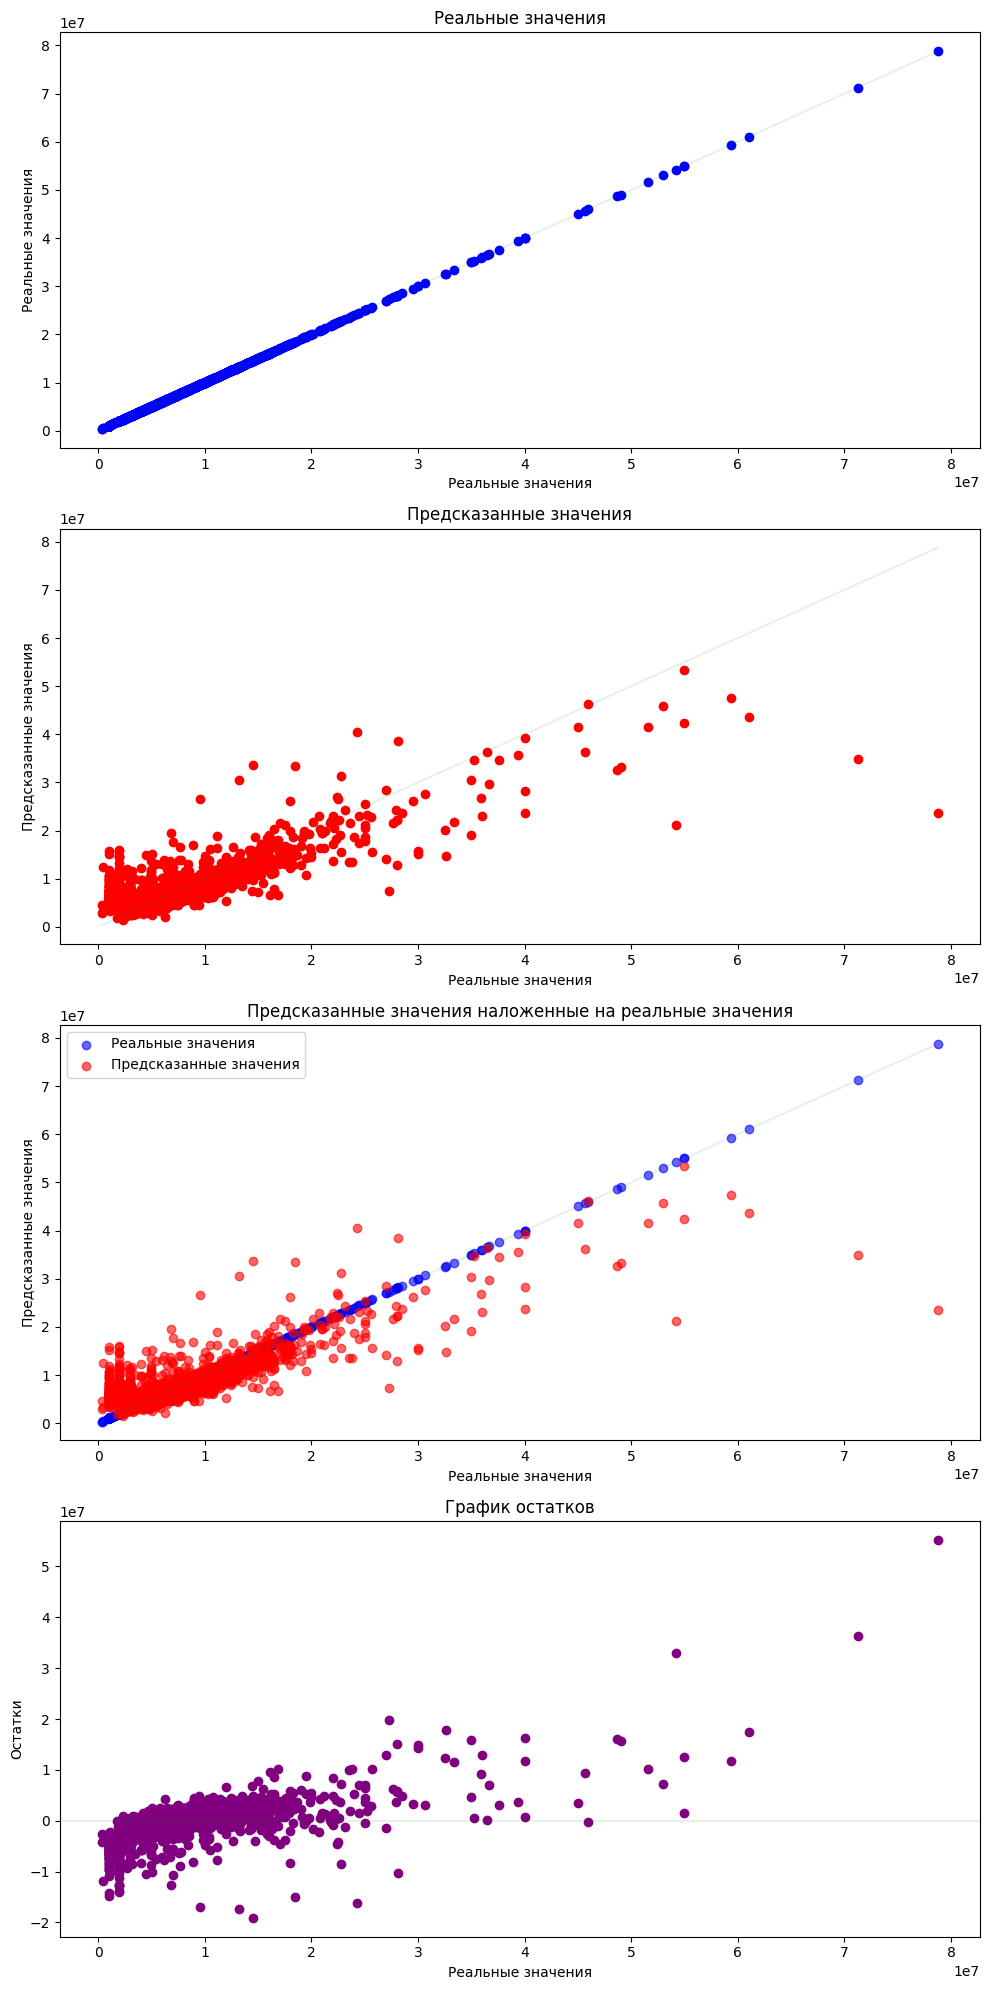

Средняя абсолютная ошибка (MAE): 1454283.5604
Среднеквадратичная ошибка (MSE): 7532477415636.1162
Коэффициент детерминации (R^2): 0.7125

Корень из среднеквадратичной ошибки (RMSE): 2744535.9199


In [44]:
plot_predictions(y_test, y_pred_cat)

In [45]:
feature_importances = model_cat.feature_importances_
feature_importances_df = pd.DataFrame({'features': list(X_test),
                                       'feature_importances': feature_importances})
feature_importances_df.sort_values('feature_importances', ascending=False)

,features,feature_importances
0,full_sq,36.751264
23,ttk_km,6.963361
25,nuclear_reactor_km,3.821493
48,year,2.848019
35,theater_km,2.619050
5,state,2.243532
2,build_year,2.119326
21,ID_railroad_station_avto,1.968847
49,building_age,1.967668
46,cafe_sum_5000_min_price_avg,1.698170


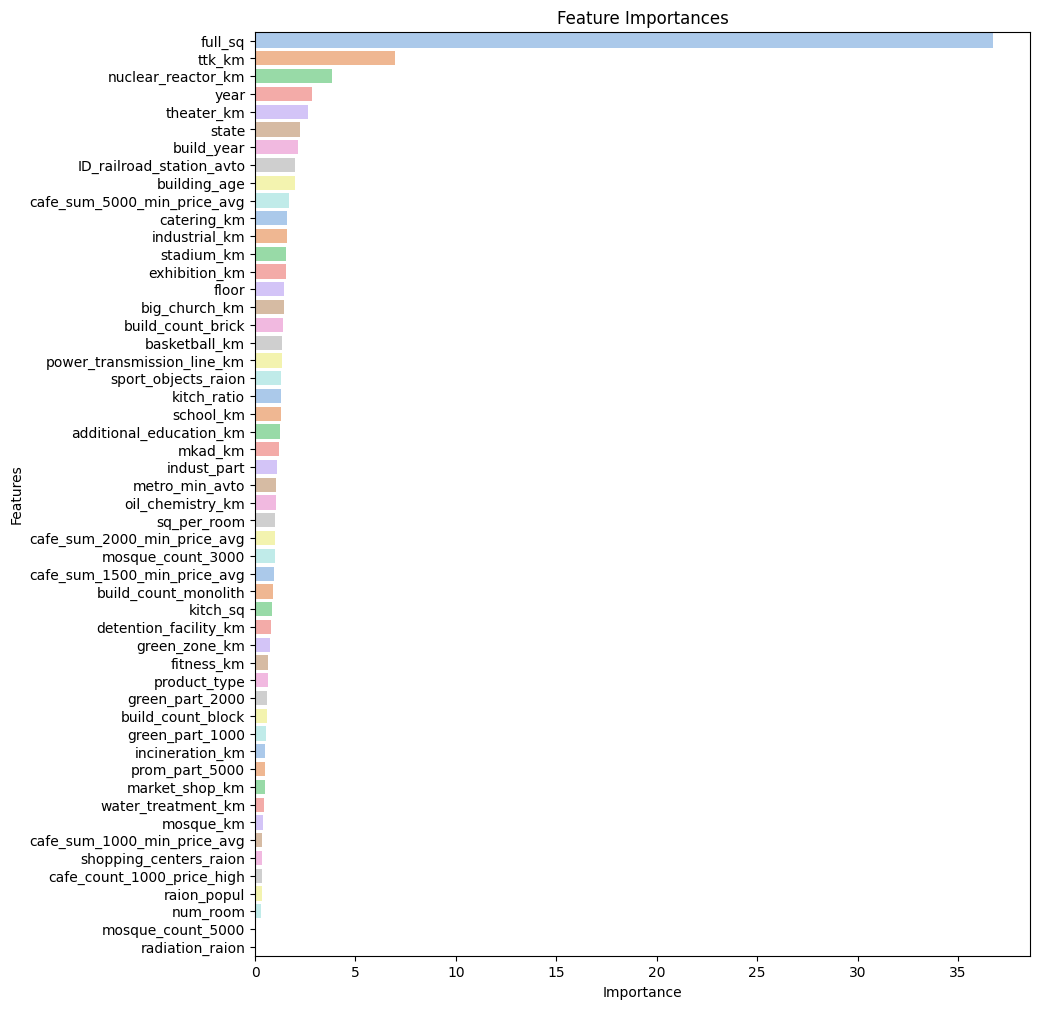

In [46]:
feature_importances = model_cat.feature_importances_
feature_importances_df = pd.DataFrame({'features': list(X_train.columns),
                                       'feature_importances': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by='feature_importances', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='feature_importances', y='features', data=feature_importances_df, palette='pastel')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

## LightGBM

In [47]:
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

In [48]:
X_train_lgbm = X_train.copy()
X_test_lgbm = X_test.copy()

for feature in categorical_features:
    X_train_lgbm[feature] = X_train_lgbm[feature].astype('category')

for feature in categorical_features:
    X_test_lgbm[feature] = X_test_lgbm[feature].astype('category')

In [49]:
train_data = lgb.Dataset(X_train_lgbm, label=y_train, categorical_feature=categorical_features)

params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'learning_rate': 0.025
}

model_lgb = lgb.train(params, train_data, 5000)

C:\Users\Professional\anaconda3\Lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8948
[LightGBM] [Info] Number of data points in the train set: 16142, number of used features: 52
[LightGBM] [Info] Start training from score 7212508.473547


In [50]:
y_pred_lgb = model_lgb.predict(X_test_lgbm, num_iteration=model_lgb.best_iteration)

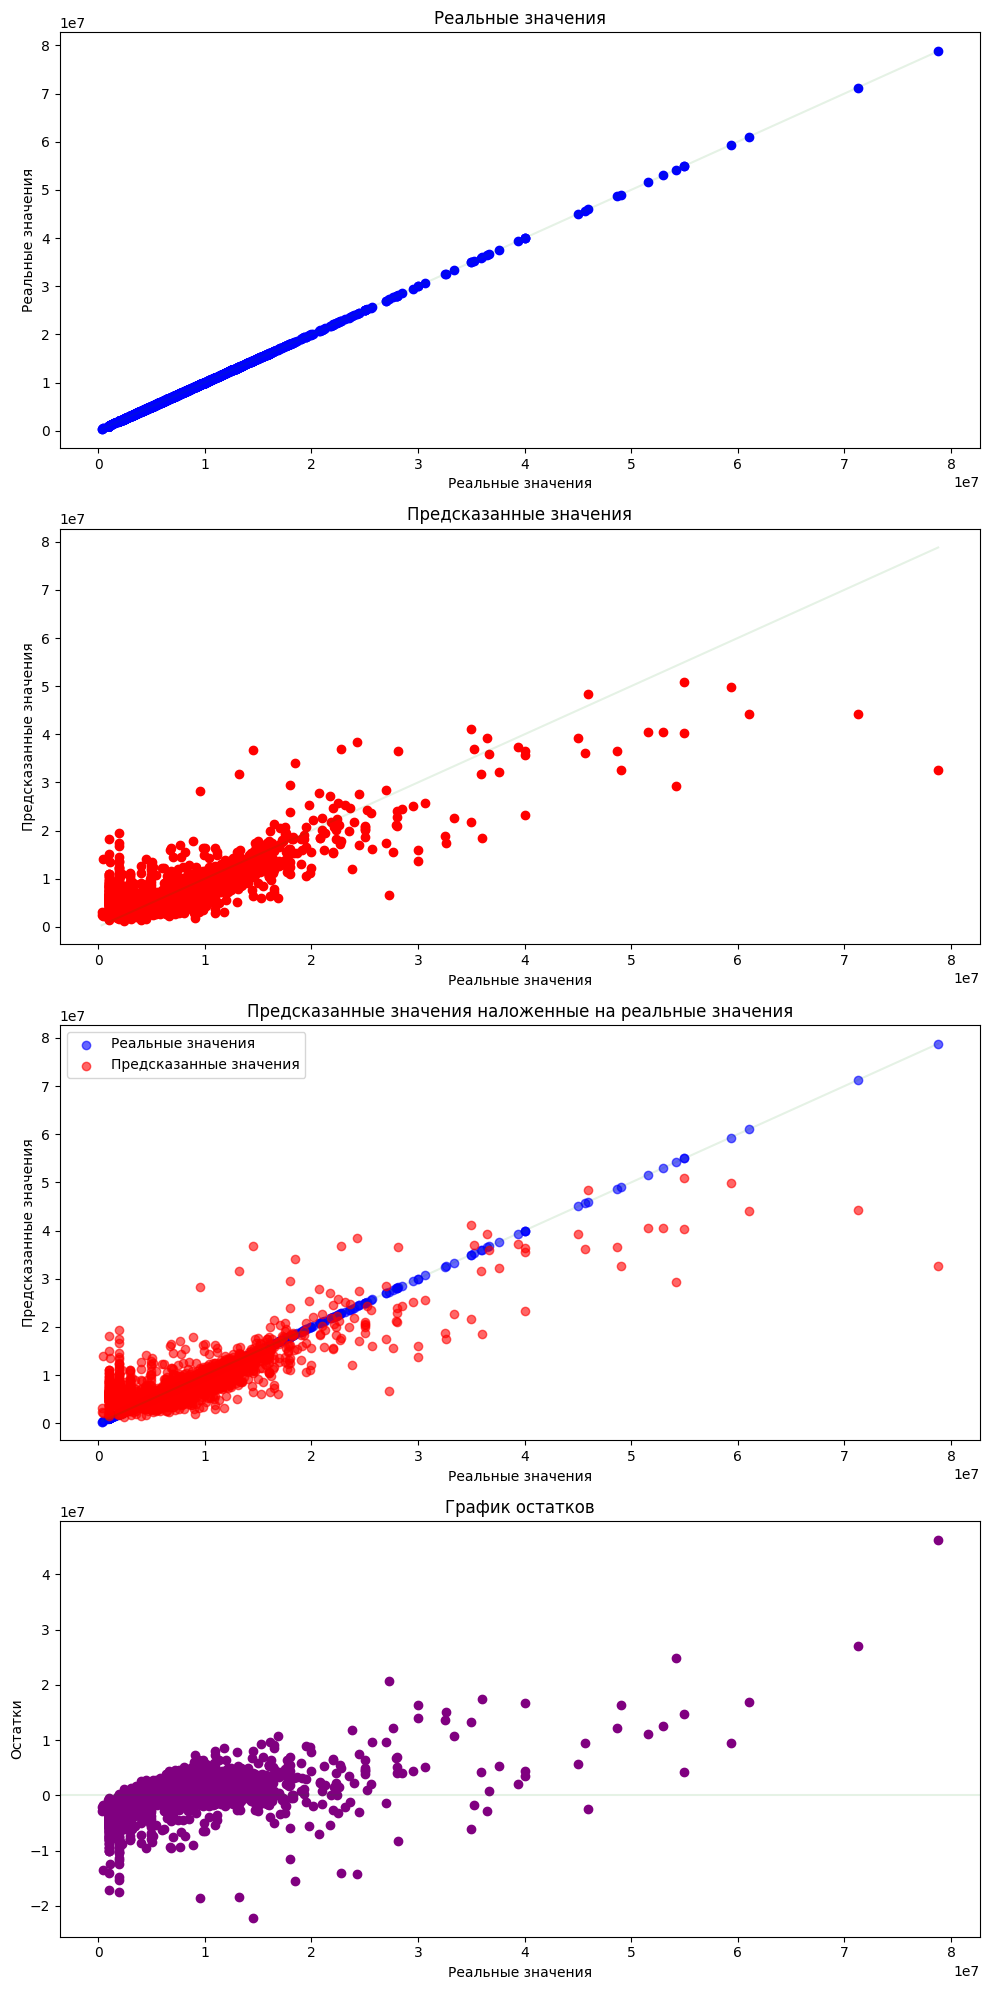

Средняя абсолютная ошибка (MAE): 1501738.7116
Среднеквадратичная ошибка (MSE): 7527768681197.9121
Коэффициент детерминации (R^2): 0.7127

Корень из среднеквадратичной ошибки (RMSE): 2743677.9478


In [51]:
plot_predictions(y_test, y_pred_lgb)

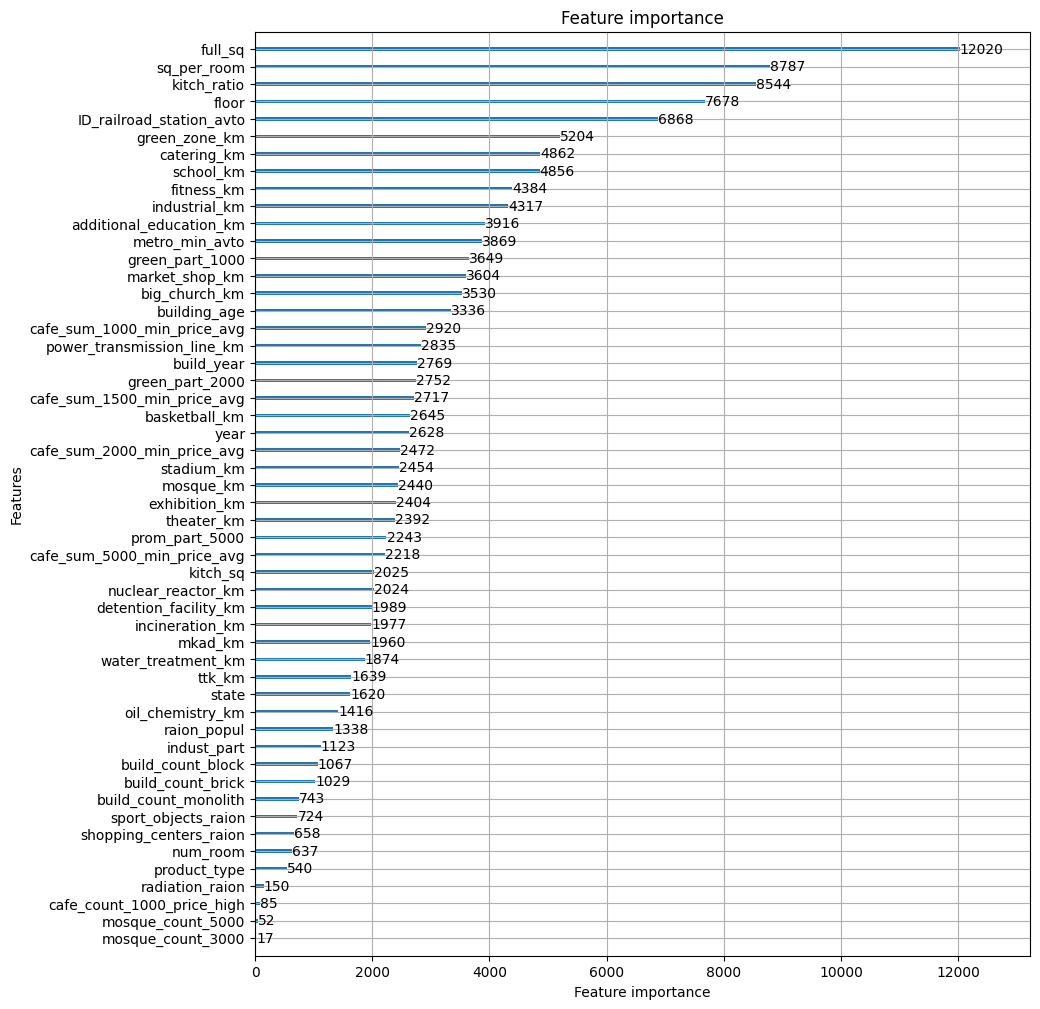

In [52]:
lgb.plot_importance(model_lgb, importance_type='split', figsize=(10, 12))
plt.show()

## XGBoost

In [53]:
X_train_xgb = X_train.copy()
X_test_xgb = X_test.copy()
X_train_xgb['ID_railroad_station_avto'] = X_train['ID_railroad_station_avto'].astype('category')
X_test_xgb['ID_railroad_station_avto'] = X_test['ID_railroad_station_avto'].astype('category')

In [54]:
dtrain = xgb.DMatrix(X_train_xgb, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test_xgb, label=y_test, enable_categorical=True)

In [55]:
params = {
    'objective': 'reg:squarederror',  
    'eval_metric': 'rmse',            
    'eta': 0.025,
    'max_depth': 7
}

model_xgb = xgb.train(params, dtrain, num_boost_round=5000)

In [56]:
y_pred_xgb = model_xgb.predict(dtest)

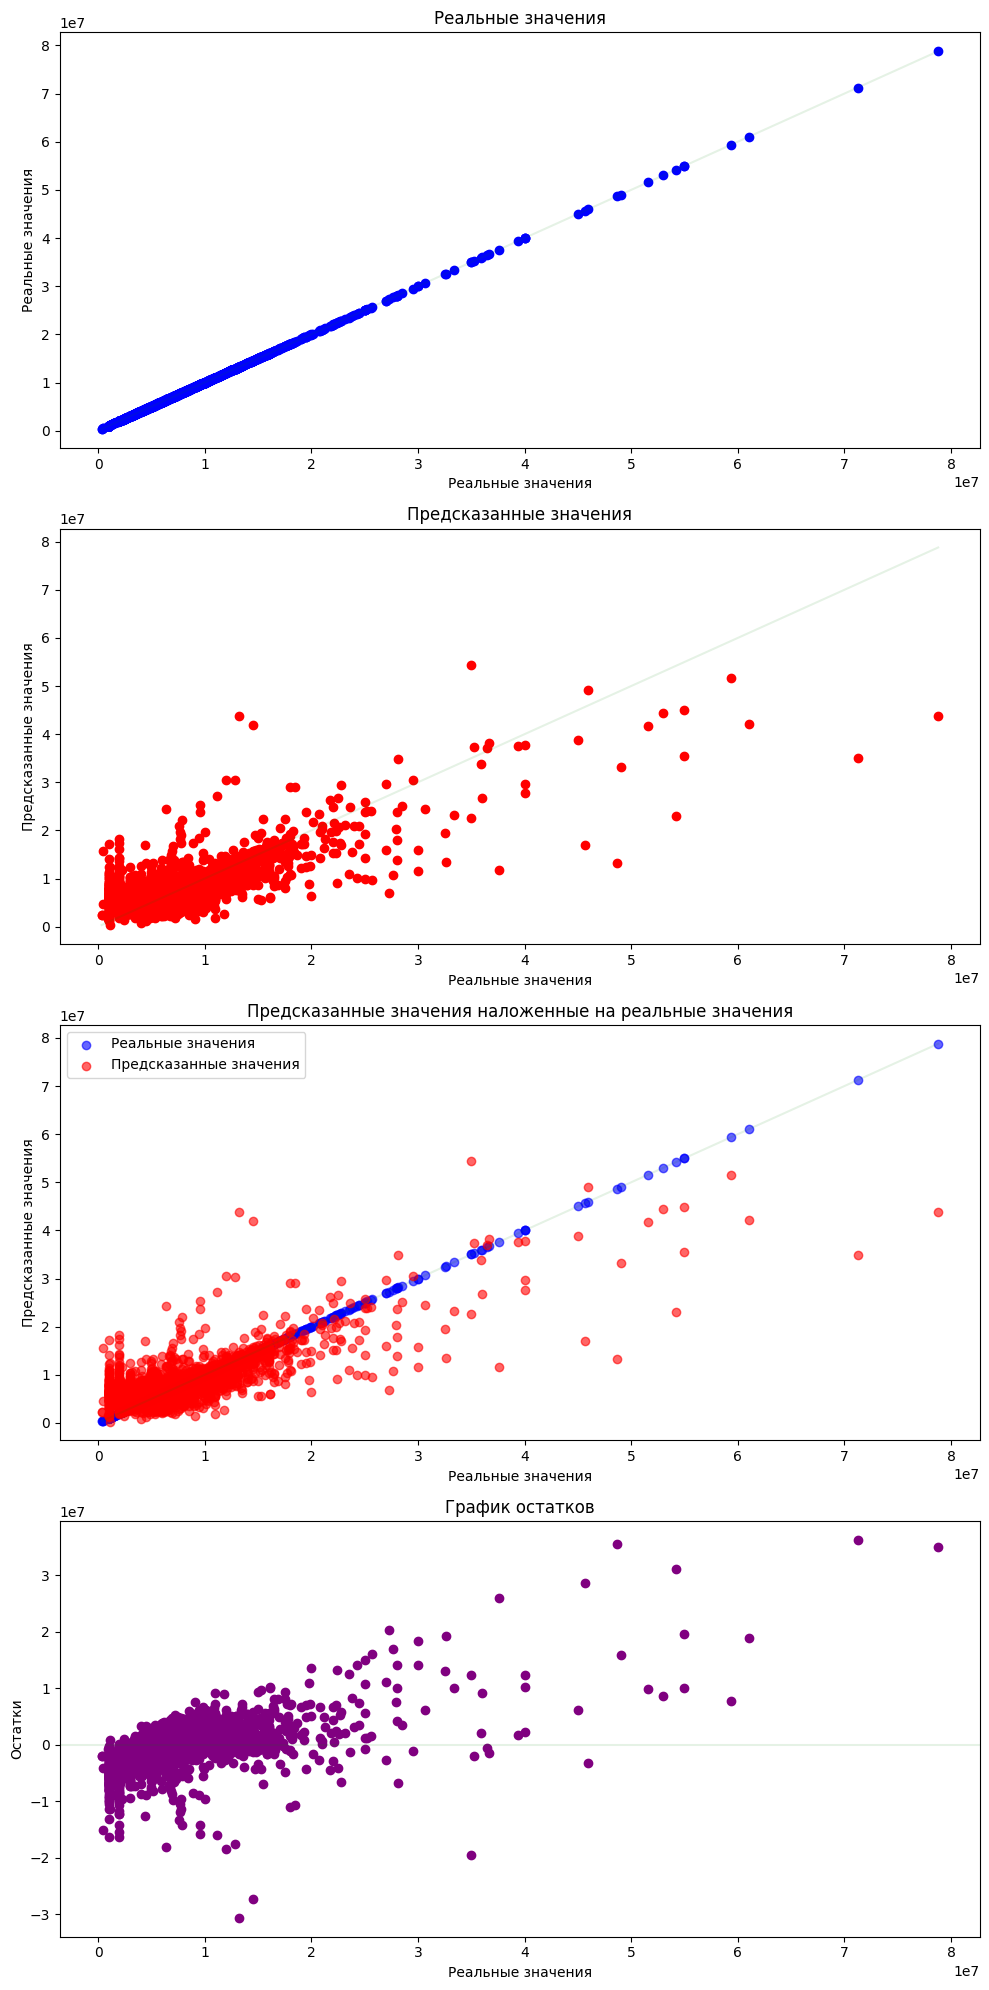

Средняя абсолютная ошибка (MAE): 1786146.9133
Среднеквадратичная ошибка (MSE): 10334808169865.5078
Коэффициент детерминации (R^2): 0.6055

Корень из среднеквадратичной ошибки (RMSE): 3214779.6456


In [57]:
plot_predictions(y_test, y_pred_xgb)

In [58]:
feature_importances = model_xgb.get_score(importance_type='weight')
feature_importances_df = pd.DataFrame({'features': list(feature_importances.keys()),
                                       'feature_importances': list(feature_importances.values())})
feature_importances_df.sort_values('feature_importances', ascending=False)

,features,feature_importances
21,ID_railroad_station_avto,61221.0
0,full_sq,55019.0
1,floor,39814.0
50,kitch_ratio,20976.0
51,sq_per_room,20646.0
2,build_year,13347.0
17,green_zone_km,10867.0
16,school_km,10676.0
15,metro_min_avto,10314.0
48,year,9660.0


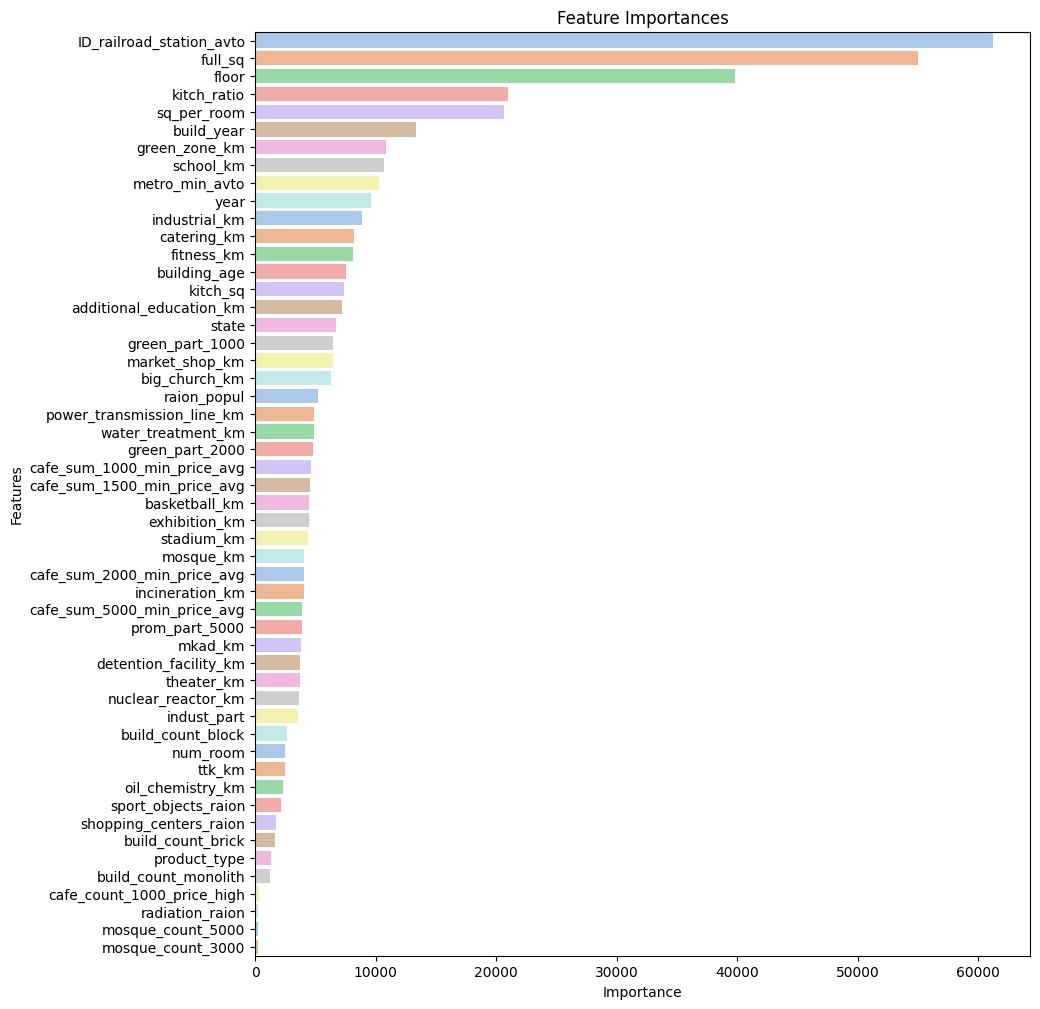

In [59]:
feature_importances = model_xgb.get_score(importance_type='weight')
feature_importances_df = pd.DataFrame({'features': list(feature_importances.keys()),
                                       'feature_importances': list(feature_importances.values())})
feature_importances_df = feature_importances_df.sort_values(by='feature_importances', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='feature_importances', y='features', data=feature_importances_df, palette='pastel')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# Прогноз

По итогу мы решили использовать Catboost, ибо он показал себя лучше остальных.

In [129]:
X = train.iloc[:, :-1]
y = train.iloc[:, -1:]

In [160]:
categorical_features_indices = [X.columns.get_loc(col) for col in X.select_dtypes(include=['object']).columns]

In [130]:
full_pool_cat = Pool(
    data=X,
    label=y,
    cat_features=categorical_features_indices
)

In [131]:
%%time

params = {'eval_metric': 'RMSE',
          'verbose': 200,
          'random_seed': 42,
          'task_type': 'GPU',
          'devices': '0',
          'iterations': 5000,
          'depth': 7,
          'learning_rate': 0.025,
          'loss_function': 'RMSE'
          }

model_cat = CatBoostRegressor(**params)
model_cat.fit(full_pool_cat)

0:	learn: 4718430.8656312	total: 34.3ms	remaining: 2m 51s
200:	learn: 2488245.2805312	total: 7s	remaining: 2m 47s
400:	learn: 2349912.7609336	total: 13.3s	remaining: 2m 32s
600:	learn: 2270738.5622536	total: 19.3s	remaining: 2m 21s
800:	learn: 2221185.2046268	total: 25.6s	remaining: 2m 14s
1000:	learn: 2176480.1473285	total: 32s	remaining: 2m 7s
1200:	learn: 2151724.7507656	total: 38.3s	remaining: 2m 1s
1400:	learn: 2135773.6299876	total: 44.8s	remaining: 1m 55s
1600:	learn: 2122342.4009393	total: 50.9s	remaining: 1m 47s
1800:	learn: 2109310.1618458	total: 57.1s	remaining: 1m 41s
2000:	learn: 2095197.1763446	total: 1m 3s	remaining: 1m 34s
2200:	learn: 2072957.1094637	total: 1m 9s	remaining: 1m 28s
2400:	learn: 2056540.6192238	total: 1m 15s	remaining: 1m 22s
2600:	learn: 2047492.7395963	total: 1m 21s	remaining: 1m 15s
2800:	learn: 2044963.6382638	total: 1m 27s	remaining: 1m 8s
3000:	learn: 2040582.4022884	total: 1m 33s	remaining: 1m 2s
3200:	learn: 2037158.5660641	total: 1m 39s	remainin

In [132]:
test_preds = model_cat.predict(test)
test_preds

array([5055351.97046741, 3958739.7526055 , 5434500.19576955, ...,
       5935335.73481559, 6940848.86410001, 6434992.14086995])

In [133]:
submission['price_doc'] = test_preds
print(submission.shape)

(9142, 1)


In [134]:
submission.to_csv('submission.csv')

In [135]:
with zipfile.ZipFile('submission.zip', 'w') as myzip:
    myzip.write('submission.csv')

По итогу на лидерборде мы получили следующий результат: 2810470.50

# Эксперименты, которые не принесли улучшения результата

## Сделать новые данные по ценовым категориям

Идея в том, что исходя из распределения таргета, мы определили семь ценовых категорий: price_bins = [0, 2_000_000, 5_000_000, 10_000_000, 20_000_000, 30_000_000, 40_000_000, 90_000_000] Путём наложения шумов мы расширили итеративно каждую из семи категорий. По итогу получили улучешние результата, расширив пятую категорию - 20_000_000 - 30_000_000. Но при добавлении данного подхода к наилучшему нашему результату, ошибка увеличиалсь. Поэтому было решено отказаться от этой идеи.

## Предсказание цены за квадрат

Идея была в том, чтобы предсказывать не всю цену квартиры, а только цену за квадрат, так как диапазон значений для регрессии был значительно меньше и распредление было более равномерное. По итогу данная идея не уменьшила ошибку.

## Предсказание по категориям площадей

Идея заключалась в том, чтобы разделить исходные данные по децилям full_sq, чтобы обучить для каждой децили отдельную модель. По итогу идея не увеньчалась успехом.

## Предсказание по  product_type

При обучении моделей, у нас бывали кейсы, когда при просмотреть важности признаков, признак product_type вставал на 3 позицию. Поэтому мы решили попробовать обучить две модели: первая будет обучаться на данных, где product_type == 0, вторая, где product_type == 1. Потом объединяем их предсказания на тестовых данных, исходя из значений product_type. По итогу данный метод не уменьшил ошибку.

## Переобучение модели

Идея была в том, чтобы переобучить модель, ибо распределение факторов +- похоже в тренировочных и в тестовых данных. По итогу это не принесло результата, возможно по причине того, что распределение таргета в тестовых данных другое.

## Замена значений у kitch_sq

## Удаление близких записей с помощью KNN

## Нормализация и стандартизация данных

## Удаление признаков, которые по идеи ухудшают результат

## Удаление выбросов у признаков

## Добавление новых признаков

## Оставить один признак из похожих

## Линейные комбинации топ признаков